# Maps of RMSSSH

## 0. Modules and libraries

In [2]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

## imports

import numpy as np
import xarray as xr
import GriddedData
import time
import cmocean

#- Other modules
import numpy.ma as ma
import WavenumberSpectrum as ws

### palette
import matplotlib.cm as mplcm

### quick plot
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
%matplotlib inline


## 1. Data 

### AVISO

In [4]:
files_aviso = !ls /media/extra/DATA/AVISO/dt_global_allsat_phy_l4_201?????_20170110.nc.gz
aviso_local = xr.open_mfdataset(files_aviso)
aviso_year = aviso_local.sel(time=slice('2012-10-01','2013-09-30'))
myadt = aviso_year.adt
rms_ssh = myadt.std(dim='time')
aviso_mssh = myadt.mean(dim='time') - myadt.mean()


### NATL60

In [5]:
ds_rms=xr.open_dataset('/media/extra/DATA/NATL60/NATL60-CJM165-MEAN/NATL60-CJM165_y2012m10-y2013m09.1y_RMSSSH.nc')
rssh=ds_rms.sossheig_rms
ds_mssh=xr.open_dataset('/media/extra/DATA/NATL60/NATL60-CJM165-S/ssh-mean/NATL60-CJM165_y2012-2013.1y_ssh-mean.nc',engine='netcdf4',lock=False)
mssh = ds_mssh.sossheig - ds_mssh.sossheig.mean()

## 2. Some functions

In [6]:
### plotting function
def north_atlantic_plot_zoom(ax,lat=None,lon=None,data=None,
                       vmin=None,vmax=None,cmap=None,title=None):
    ax.coastlines(resolution="10m")

    #- gridlines
    # see http://scitools.org.uk/cartopy/docs/latest/matplotlib/gridliner.html
    #gl = ax.gridlines(draw_labels=True)
    gl = ax.gridlines(crs=pj, draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')

    label_style = {'size': 12, 'color': 'black', 'weight': 'bold'}

    gl.xlabel_style = label_style
    gl.xlabels_bottom = False
    gl.xlocator = mticker.FixedLocator(np.arange(-90,10,5,dtype=float))

    gl.ylabel_style = label_style
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator(np.arange(20,80,5,dtype=float))

    # pcolormesh
    cs = plt.pcolormesh(lon, lat, data,transform=pj,cmap=cmap,vmin=vmin,vmax=vmax)

    # limits
    plt.xlim((-75,-45))
    plt.ylim((30,55)) 

    #colorbar
    cb = plt.colorbar(cs, extend='both', fraction=0.042, pad=0.04, orientation="horizontal")

    cb.ax.tick_params(labelsize=14)
    
    plt.title(title,y=1.05, size=20)

In [7]:
# normalization
def normalize(data=None,lat=None,lon=None): # not clean : not area weighted
    # data is a masked array, 
    # lat, lon can be xr.dataarray
    alon = np.mod( lon + 180,360) - 180
    alat = np.array(lat)
    condition =     (alat >27) * (alat <65) * (alon >-80) * (alon < 3)
    refvalue = np.mean(data[np.where(condition)])
    return data - refvalue

## 3. Maps of RMSSSH

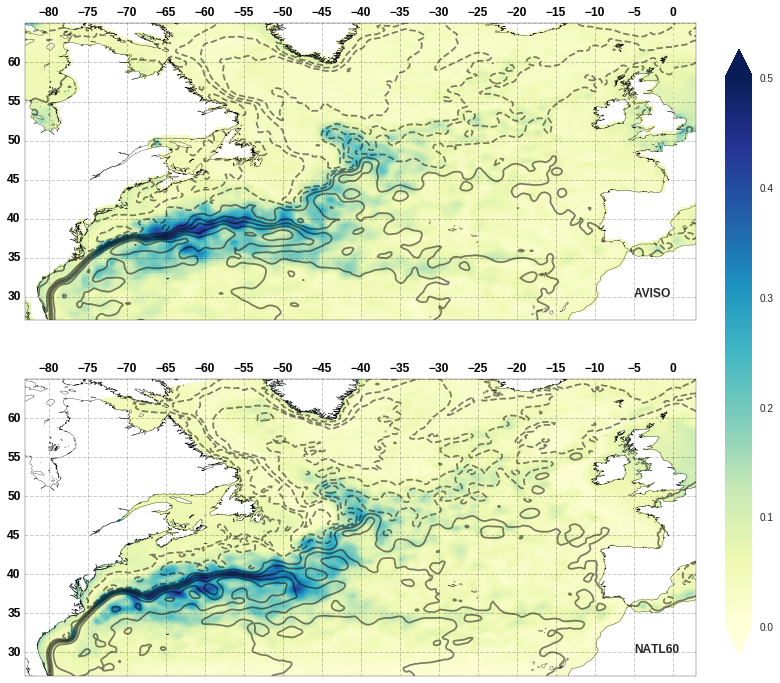

In [9]:
fig=plt.figure(figsize=(15,12))
pj = ccrs.PlateCarree()
ax = plt.subplot(211,projection=pj)
ax.coastlines(resolution="10m")

gl = ax.gridlines(crs=pj, draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')

label_style = {'size': 12, 'color': 'black', 'weight': 'bold'}

gl.xlabel_style = label_style    
gl.xlabels_bottom = False
gl.xlocator = mticker.FixedLocator(np.arange(-90,10,5,dtype=float))

gl.ylabel_style = label_style
gl.ylabels_right = False
gl.ylocator = mticker.FixedLocator(np.arange(20,80,5,dtype=float))

# pcolormesh
aviso_mssh = myadt.mean(dim='time') - myadt.mean()
rms_ssh=myadt.std(dim='time')
data = rms_ssh.to_masked_array()
lat = rms_ssh.latitude
lon = rms_ssh.longitude

lon2d,lat2d = np.meshgrid(lon,lat)


cs = plt.pcolormesh(lon, lat, data,transform=pj,cmap=mplcm.YlGnBu,vmin=0,vmax=0.5)

data = aviso_mssh.to_masked_array()
data = normalize(data=data,lat=lat2d,lon=lon2d)

contour=ax.contour(lon, lat,data,np.arange(-1,1,0.15),colors='k',alpha=0.5,linewidth=0.0001,antialiased=True)

# limits
plt.xlim((-83,3))
plt.ylim((27,65)) 

    
#plt.title('Mean geostrophic current speed (m/s) AVISO',y=1.05, size=20)
plt.text(-5, 30,'AVISO',fontsize=12,weight='bold')

ax = plt.subplot(212,projection=pj)

ax.coastlines(resolution="10m")

gl = ax.gridlines(crs=pj, draw_labels=True,
                  linewidth=1, color='black', alpha=0.2, linestyle='--')

label_style = {'size': 12, 'color': 'black', 'weight': 'bold'}

gl.xlabel_style = label_style    
gl.xlabels_bottom = False
gl.xlocator = mticker.FixedLocator(np.arange(-90,10,5,dtype=float))

gl.ylabel_style = label_style
gl.ylabels_right = False
gl.ylocator = mticker.FixedLocator(np.arange(20,80,5,dtype=float))

# pcolormesh
data = rssh.isel(time_counter=0).to_masked_array()
lat = ds_rms.nav_lat
lon = ds_rms.nav_lon


cs = plt.pcolormesh(lon, lat, np.squeeze(data),transform=pj,cmap=mplcm.YlGnBu,vmin=0,vmax=0.5)


data = mssh.isel(time_counter=0).to_masked_array()

data = normalize(data=data,lat=lat,lon=lon)
contour=ax.contour(lon, lat,data,np.arange(-1,1,0.15),colors='k',alpha=0.5,linewidth=0.0001,antialiased=True)

# limits
plt.xlim((-83,3))
plt.ylim((27,65)) 

#plt.title('Mean geostrophic current speed (m/s) NATL60',y=1.05, size=20)
plt.text(-5, 30,'NATL60',fontsize=12,weight='bold')

#colorbar
#cb = plt.colorbar(cs, extend='both', fraction=0.042, pad=0.04, orientation="horizontal")

#cb.ax.tick_params(labelsize=14)

cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
fig.colorbar(cs, cax=cbar_ax, extend='both', orientation="vertical")

    

plt.savefig('Mean_RMSSSH_AVISO_NATL60.png',bbox_inches='tight')